# 分析Prosper数据——EDA

## 目录
* [项目综述](#项目综述)
* [分析过程](#分析过程)
 * [了解数据内容](#了解数据内容)
 * [单变量分析](#单变量分析)

### 项目综述
项目数据源是Prosper的数据。Prosper是美国一家不同于传统借贷的P2P借贷服务的公司，服务内容是贷款人贷款和借款人获取投资收益，而公司收益是从贷方和借方收取服务费。本次项目是站在投资人的角度，投资的收益是从借款人如约还款来实现，利用EDA的思路分析投资价值——因此需要分析借款人的借款信息和还款信息，期望能够证实P2P借贷方式存在投资价值。

In [1]:
library(ggplot2)
library(RColorBrewer)
library(psych)
library(dplyr)
library(tidyr)
library(reshape2)
library(gridExtra)


Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# load data
rawprosper <- read.csv("prosperLoanData.csv", sep=",", stringsAsFactor=FALSE)

In [3]:
dim(rawprosper)

[1] 113937     81

In [4]:
# know the structure of the data
str(rawprosper)

'data.frame':	113937 obs. of  81 variables:
 $ ListingKey                         : chr  "1021339766868145413AB3B" "10273602499503308B223C1" "0EE9337825851032864889A" "0EF5356002482715299901A" ...
 $ ListingNumber                      : int  193129 1209647 81716 658116 909464 1074836 750899 768193 1023355 1023355 ...
 $ ListingCreationDate                : chr  "2007-08-26 19:09:29.263000000" "2014-02-27 08:28:07.900000000" "2007-01-05 15:00:47.090000000" "2012-10-22 11:02:35.010000000" ...
 $ CreditGrade                        : chr  "C" "" "HR" "" ...
 $ Term                               : int  36 36 36 36 36 60 36 36 36 36 ...
 $ LoanStatus                         : chr  "Completed" "Current" "Completed" "Current" ...
 $ ClosedDate                         : chr  "2009-08-14 00:00:00" "" "2009-12-17 00:00:00" "" ...
 $ BorrowerAPR                        : num  0.165 0.12 0.283 0.125 0.246 ...
 $ BorrowerRate                       : num  0.158 0.092 0.275 0.0974 0.2085 ...
 $ LenderY

In [5]:
print(sort(names(rawprosper)))

 [1] "AmountDelinquent"                    "AvailableBankcardCredit"            
 [3] "BankcardUtilization"                 "BorrowerAPR"                        
 [5] "BorrowerRate"                        "BorrowerState"                      
 [7] "ClosedDate"                          "CreditGrade"                        
 [9] "CreditScoreRangeLower"               "CreditScoreRangeUpper"              
[11] "CurrentCreditLines"                  "CurrentDelinquencies"               
[13] "CurrentlyInGroup"                    "DateCreditPulled"                   
[15] "DebtToIncomeRatio"                   "DelinquenciesLast7Years"            
[17] "EmploymentStatus"                    "EmploymentStatusDuration"           
[19] "EstimatedEffectiveYield"             "EstimatedLoss"                      
[21] "EstimatedReturn"                     "FirstRecordedCreditLine"            
[23] "GroupKey"                            "IncomeRange"                        
[25] "IncomeVerifiable"     

### 了解数据内容
该数据集的观测值为113937个，具有81个变量。变量中包括了借款人的信息：借款人类似ID信息(MemberKey)，借款人借款开始日期(LoanOriginationDate)，借款人所在州(BorrowerState)，收入范围(IncomeRange)，债务收入比(DebtToIncomeRatio)，职业(Occupation)，借款人工作期间(EmploymentStatusDuration)，借款人工作状态(EmploymentStatus)，借款总额度(LoanOriginalAmount)，还款策略(Term)，账户信用等级(ProsperRating..Alpha.)，借款后进过月数(LoanMonthsSinceOrigination)，交易数量(TotalTrades)，未发生延期交易的比例(TradesNeverDelinquent..percentage.)，账户还款的次数()；另一方面，承担借款额的投资人人数(Investor)，投资款来自朋友的投资人数(InvestmentFromFriendsCount)，来自朋友投资的投资额(InvestmentFromFriendsAmount)。
以上也是本次分析的参考的变量，主要是考虑从了解借款人的收入、债务信息的侧写；另一方面也需要分析投资人在借款人中借款额度中影响，从两个方面去了解借款人的借款合理性、还款能力。以期待能了解Prosper借款用户的特点，分析其投资价值。

In [6]:
# change the data type
rawprosper$LoanOriginationDate <- as.Date(rawprosper$LoanOriginationDate)
rawprosper$MemberKey <- factor(rawprosper$MemberKey)
rawprosper$ProsperRating..Alpha. <- ordered(rawprosper$ProsperRating..Alpha., levels=unique(rawprosper$ProsperRating..Alpha.), 
                                            labels=c("NA", "HR", "E","D", "C", "B", "A", "AA"))
rawprosper$IncomeRange <- ordered(rawprosper$IncomeRange,levels=unique(rawprosper$IncomeRange),
                                 labels=c("$0", "$1-24,999", "$25,000-49,999", "$50,000-74999", "$75,000-99,999", "$100,000+", "Not employed","Not displayed"))
rawprosper$Occupation <- factor(rawprosper$Occupation)
rawprosper$EmploymentStatus <- factor(rawprosper$EmploymentStatus)

In [7]:
# analysis the total loan amount in every month
Loanamount <- rawprosper %>% 
    mutate(DateMonth=format(LoanOriginationDate, "%Y/%m/1")) %>%
    group_by(DateMonth) %>%
    summarise(LoanMean=mean(LoanOriginalAmount), LoanTotal=sum(LoanOriginalAmount),
              LoanMedian=median(LoanOriginalAmount),Loan75=quantile(LoanOriginalAmount, .75),
              Loan25=quantile(LoanOriginalAmount, .25), LoanNumber=n()) %>%
    arrange(DateMonth)
Loanamount$DateMonth <- as.Date(Loanamount$DateMonth)

In [8]:
head(Loanamount, 5)

DateMonth,LoanMean,LoanTotal,LoanMedian,Loan75,Loan25,LoanNumber
2005-11-01,3676.923,47800,2500,4800,1000,13
2005-12-01,3431.889,30887,3000,3500,2689,9
2006-01-01,5640.000,45120,4750,7750,3000,8
2006-02-01,6196.356,452334,5000,8800,3000,73
2006-03-01,4542.449,1062933,3000,5000,2500,234


In [9]:
tail(Loanamount, 5)

DateMonth,LoanMean,LoanTotal,LoanMedian,Loan75,Loan25,LoanNumber
2013-11-01,10994.75,47673231,10000,15000,5000,4336
2013-12-01,11732.21,61183465,10000,15000,6000,5215
2014-01-01,11786.46,69127601,10000,15000,6500,5865
2014-02-01,11964.88,53662504,10000,15000,6800,4485
2014-03-01,12187.39,22205431,10000,15000,7000,1822


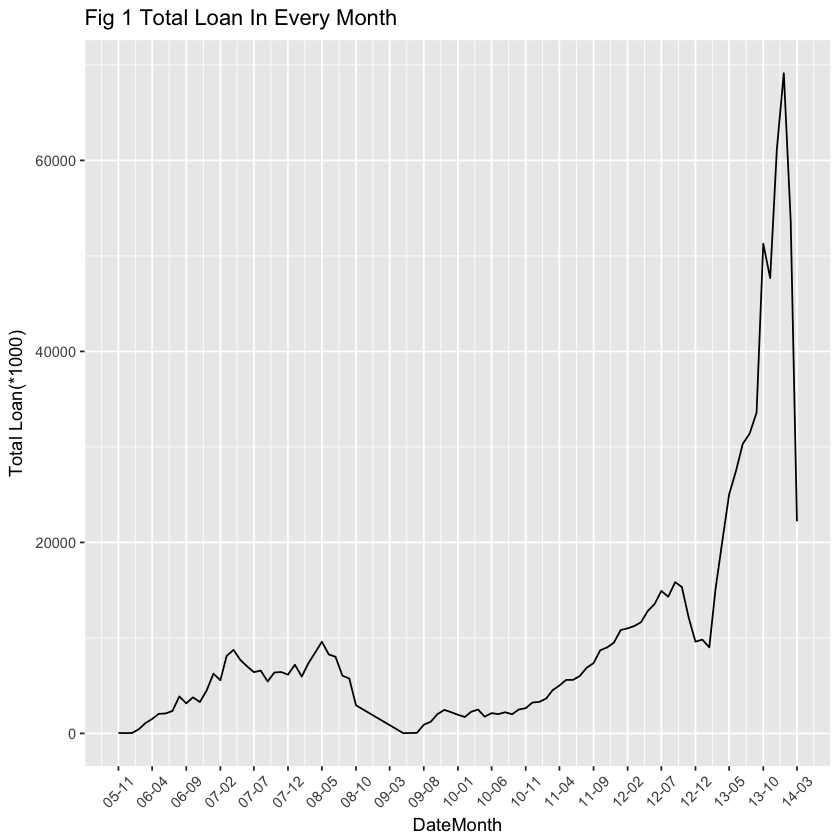

In [10]:
# plot the total loan in every month
ggplot() +
    geom_line(aes(x=DateMonth, y=LoanTotal/1000), data=Loanamount) +
    scale_x_date(date_breaks="5 months", date_labels="%y-%m") +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) +
    ggtitle("Fig 1 Total Loan In Every Month") +
    ylab("Total Loan(*1000)")

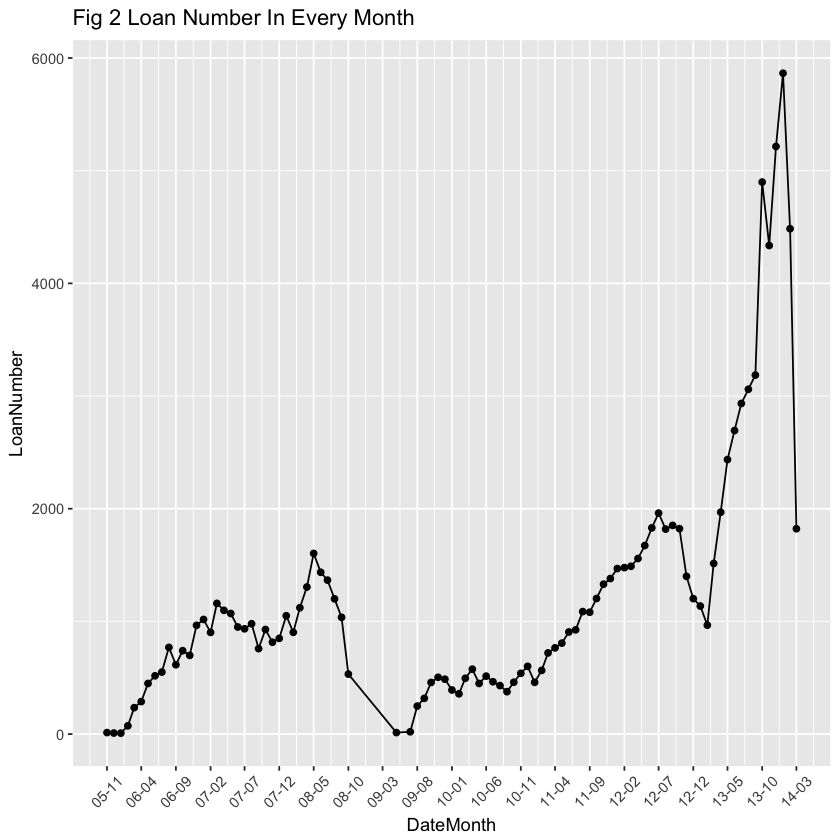

In [11]:
# plot loan number in every month
ggplot(aes(x=DateMonth, y=LoanNumber), data=Loanamount) +
    geom_point() +
    geom_path() +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) +
    ggtitle("Fig 2 Loan Number In Every Month") +
    scale_x_date(date_breaks="5 months", date_labels="%y-%m")

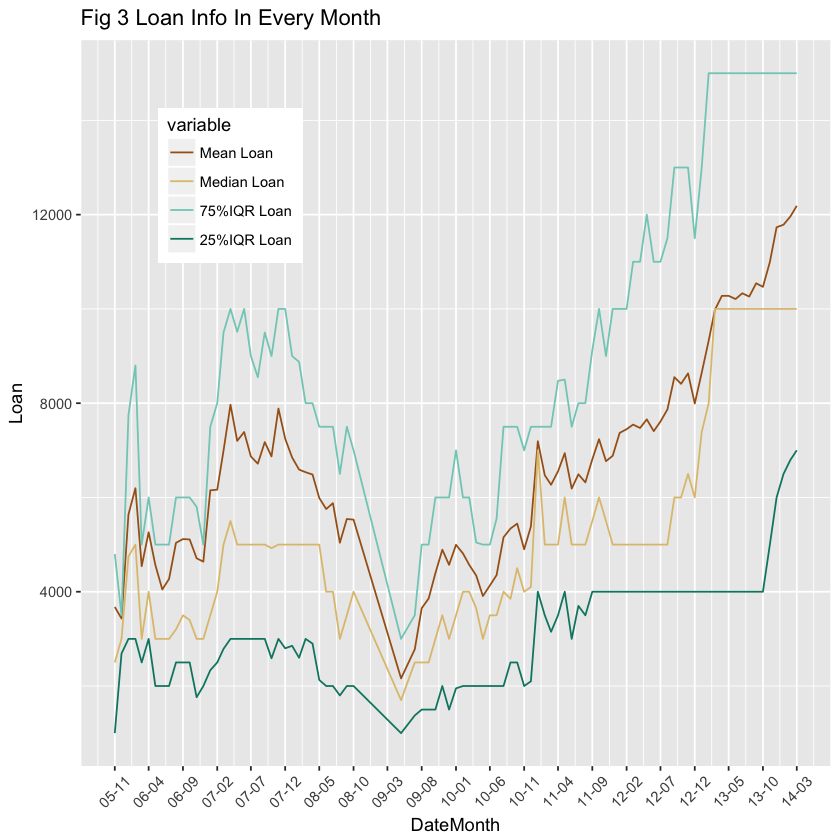

In [12]:
# plot the another stat infomation about loan in every month
Loaninfo <- melt(subset(Loanamount, select=c("DateMonth", "LoanMean", "LoanMedian", "Loan75", "Loan25")),
                 id="DateMonth", measured=c("LoanMean", "LoanMedian", "Loan75", "Loan25"))
Loaninfo$variable <- factor(Loaninfo$variable,
                            levels=c("LoanMean", "LoanMedian", "Loan75", "Loan25"),
                            labels=c("Mean Loan", "Median Loan", "75%IQR Loan", "25%IQR Loan"))

ggplot(aes(x=DateMonth, y=value), data= Loaninfo) +
    geom_line(aes(color=variable)) +
    theme(legend.position=c(0.2,.8)) +
    scale_x_date(date_breaks="5 months", date_labels="%y-%m") +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) +
    ggtitle("Fig 3 Loan Info In Every Month") +
    ylab("Loan") +
    scale_color_brewer(type="div")

### 单变量分析
1. Prosper平台贷款状况

以上分析了平台上2005年11月至2014年3月份期间的贷款额，从Fig 1每月贷款额的变化和Fig 2每月交易数量：1)整体趋势上，每月的贷款额在增加。到2013年10月至2014年3月出现了贷款总额快速降低的趋势(降低了近5亿)；2)在2008年10月至2009年8月期间，线段平滑下降。经证实该平台发生了暂停交易，对平台交易可能存在影响；3)2009年8月至2013年10月是Prosper平台高速发展对阶段。从Fig 3每月贷款对其他其他统计信息来看，平台的贷款额表现还是比较优异——平均贷款额的趋势也是在2009年3月之后开始快速提高，另外在小额贷款一直发展缓慢，但是在8000以上的贷款额度发展比较快速。

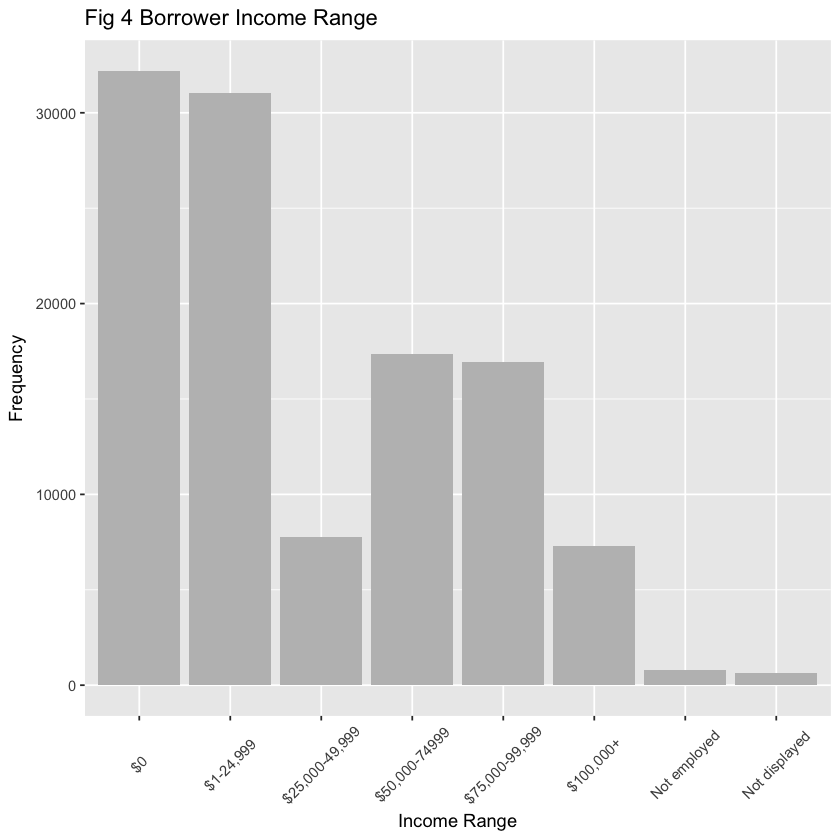

In [13]:
# plot the borrower income range
ggplot(aes(IncomeRange), data=rawprosper) +
    geom_bar(fill="grey") +
    xlab("Income Range") +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) +
    ggtitle("Fig 4 Borrower Income Range") +
    ylab("Frequency")

In [14]:
p1 <- ggplot(aes(IncomeRange), data=rawprosper) +
    geom_bar(fill="grey") +
    xlab("Income Range") +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) +
    ggtitle("Fig 4 Borrower Income Range") +
    ylab("Frequency")
p2 <- ggplot(aes(LoanOriginalAmount), data=rawprosper) +
    geom_bar() +


ERROR: Error in parse(text = x, srcfile = src): <text>:10:0: unexpected end of input
8:     geom_bar() +
9: 
  ^


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): argument "x" is missing, with no default


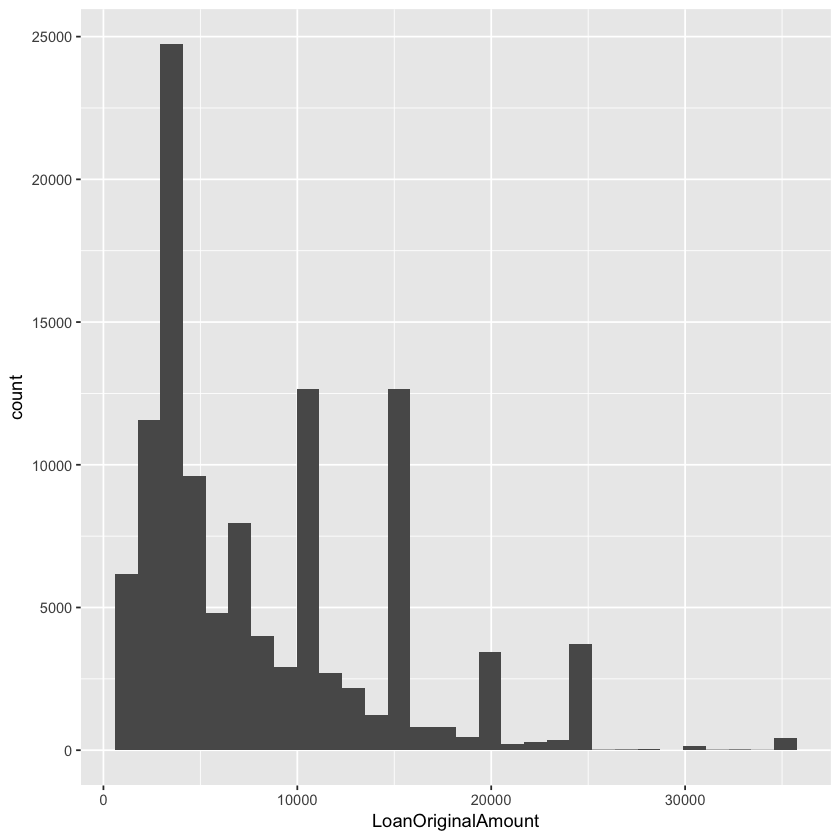

In [34]:
ggplot(aes(LoanOriginalAmount), data=rawprosper) +
    geom_histogram() +
    geom_hline(v=mean(rawprosper$LoanOriginalAmount), color="red", legend=)

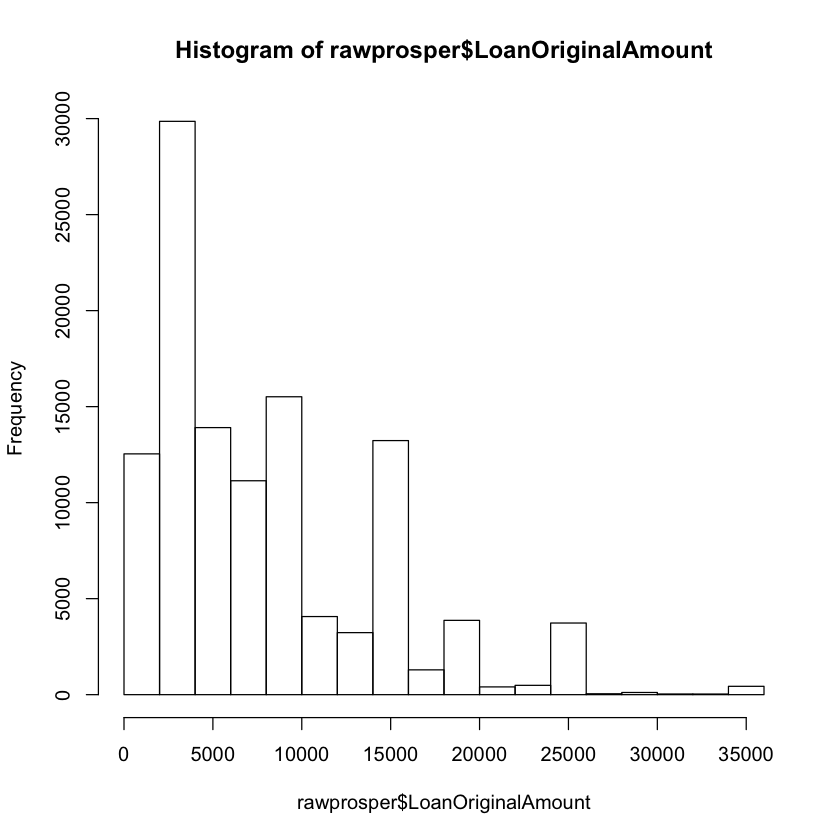

In [36]:
hist(rawprosper$LoanOriginalAmount,)